# Under- and overfitting, model selection

## Preliminaries

In the first set of exercises you had to implement the training and evaluation of the linear regression and $k$-NN methods from scratch in order to practice your `numpy` skills. From this set of exercises onward, you can use the implementations provided in `scikit-learn` or other higher-level libraries. We start this set of exercises by demonstrating some of the features of `scikit-learn`.

For example, implementation of linear regression model fitting with an analytical solution for the parameters is provided by the class `sklearn.linar_model.LinearRegression`. You can train a linear regression model in the following way:

In [52]:
import numpy as np
from sklearn import datasets, linear_model

# load the diabetes dataset
diabetes = datasets.load_diabetes()

# use only one feature
X = diabetes.data[:, np.newaxis, 2]
y = diabetes.target

# split the data into training/testing sets
X_train = X[:-20]
X_test = X[-20:]

# split the targets into training/testing sets
y_train = y[:-20]
y_test = y[-20:]

# create linear regression object
model = linear_model.LinearRegression()

# train the model using the training dataset
model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

Let's visualize the training dataset and the learned regression model.

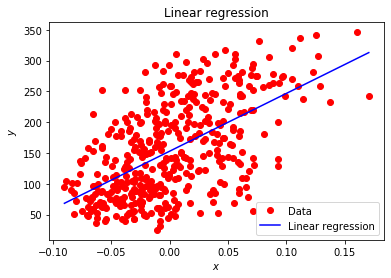

In [53]:
%matplotlib inline
import matplotlib.pyplot as plt

fig = plt.figure()
plt.plot(X_train, y_train, 'r.', markersize=12)
X_edge = np.array([np.min(X_train, 0), np.max(X_train, 0)])
plt.plot(X_edge, model.predict(X_edge), 'b-')
plt.legend(('Data', 'Linear regression'), loc='lower right')
plt.title('Linear regression')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.show()

Once trained, the model can be used to make predictions on the test data:

In [54]:
# Make predictions using the testing dataset
prediction = model.predict(X_test)

The next step (not shown here) is to evaluate the performance of the trained model.

Note that the `scikit-learn` interface works by first initializing an object from the class that implements the machine learning model (linear regression in this case) and then fitting the initialized model using the data in the training set. Finally, the trained (fitted) model can be used to make predictions on unseen data. In fact, all models implemented in this library follow the same *initialize-fit-predict* programming interface. For example, a $k$-NN classifier can be trained in the following way:

In [55]:
from sklearn.model_selection import train_test_split
from sklearn import datasets, neighbors

breast_cancer = datasets.load_breast_cancer()

X = breast_cancer.data
y = breast_cancer.target

# make use of the train_test_split() utility function instead
# of manually dividing the data
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=40)

# initialize a 3-NN classifier
model = neighbors.KNeighborsClassifier(n_neighbors=3)

# train the model using the training dataset
model.fit(X_train, y_train)

# make predictions using the testing dataset
prediction = model.predict(X_test)

Note that the features in the breast cancer dataset have different scales (some have on average very small absolute values, and some very large), which means that the distance metric used by $k$-NN will me dominated by the features with large values. You can use any of the number of feature transformation methods implemented in `scikit-learn` to scale the features. For example, you can use the `sklearn.preprocessing.StandardScaler` method to transform all features to a have a zero mean and unit variance:

In [56]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)

The scaler has its own parameters which are the means and standard deviations of the features estimated from the training set. If you train a model with the scaled features, you will have to remember to also apply the scaling transformation every time you make a prediction on new unseen and unscaled data. This is somewhat prone to error. One option for making the code more robust is to create a processing pipeline that includes the scaling and $k$-NN models in a sequence:

In [57]:
from sklearn.pipeline import Pipeline

knn = neighbors.KNeighborsClassifier(n_neighbors=3)

model = Pipeline([
                 ("scaler", scaler),
                 ("knn", knn)
                ])

# train the model using the training dataset
model.fit(X_train, y_train)

# make predictions using the testing dataset
prediction = model.predict(X_test)


If you are curious, more information about the design of the `scikit-learn` application programming interface (API) can be found [in this paper](https://arxiv.org/pdf/1309.0238.pdf). 

## Exercises

### Bias-variance decomposition

Show that the mean squared error of the estimate of a parameter can be decomposed into an expression that includes both the bias and variance (Eq. 5.53-5.54 in "Deep learning" by Goodfellow et al.). 

## Derivation

Eq 5.53 states that the MSE can be defined as: $ MSE = E[( \^{\theta}_{m} - \theta)^2] $ Where E represents the expected value, or in other words, the average value of a variable over all samples. $E[\^{\theta}_{m}]$ would therefore be the average value of estimator $\^{\theta}_{m}$ over all possible samples in the dataset.

We can introduce $\^{\theta}_{m}$ into the first expression as follows:
$$
MSE = E[( \^{\theta}_{m} - E[\^{\theta}_{m}] + E[\^{\theta}_{m}] - \theta)^2]
$$

We can expand this term as follows:
$$
MSE = E[( \^{\theta}_{m} - E[\^{\theta}_{m}])^2] + 2E[( \^{\theta}_{m} - E[\^{\theta}_{m}])(E[\^{\theta}_{m}] - \^{\theta}_{m})] + (E[\^{\theta}_{m}] - \theta)^2
$$
Note that the last term does not have an E in front of it, because it is a constant value and therefore does not really have a meaningful expected value. In addition, the second term $2E[( \^{\theta}_{m} - E[\^{\theta}_{m}])(E[\^{\theta}_{m}] - \^{\theta}_{m})]$ is equal to zero as $E[ \^{\theta}_{m} - E[\^{\theta}_{m}]] = 0$. We can now reduce the earlier definition to:

$$
MSE = E[( \^{\theta}_{m} - E[\^{\theta}_{m}])^2] + (E[\^{\theta}_{m}] - \theta)^2
$$

Where $E[( \^{\theta}_{m} - E[\^{\theta}_{m}])^2]$ is the variance of the estimator and $(E[\^{\theta}_{m}] - \theta)^2$ is the bias of the estimator.

This leads to the final expression:
$$
MSE = Variance(\^{\theta}_{m}) + Bias(\^{\theta}_{m})^2
$$

### Polynomial regression

For this exercise we will be using generated data to better show the effects of the different polynomial orders.
The data is created using the make_polynomial_regression function.

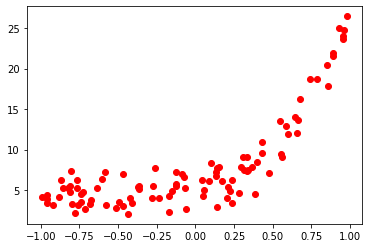

In [58]:
%matplotlib inline

def generate_dataset(n=100, degree=1, noise=1, factors=None):
    # Generates a dataset by adding random noise to a randomly
    # generated polynomial function.
    
    x = np.random.uniform(low=-1, high=1, size=n)
    
    factors = np.random.uniform(0, 10, degree+1)
    
    y = np.zeros(x.shape)
    
    for idx in range(degree+1):
        y += factors[idx] * (x ** idx)

    # add noise
    y += np.random.normal(-noise, noise, n)
    
    return x, y

# load generated data
np.random.seed(0)

X_rand, y_rand = generate_dataset(n=100, degree=4, noise=1.5)

plt.plot(X_rand, y_rand, 'r.', markersize=12)

Implement polynomial regression using the `sklearn.preprocessing.PolynomialFeatures` transformation. Using the `sklearn.grid_search.GridSearchCV` class, perform a grid search of the polynomial order hyperparameter space with cross-validation and report the performance on an independent test set.

Plot a learning curve that show the validation accuracy as a function of the polynomial order. 

<p><font color='#770a0a'>Which models have a high bias, and which models have high variance? Motivate your answer.</font><p>
    
Repeat this experiment, this time using the diabetes dataset instead of the generated data.

## Experiment 1: using the randomly generated data

In [59]:
#importing all necessary modules
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error

In [60]:
#Creating data
X_train, X_val, y_train, y_val = train_test_split(X_rand, y_rand, test_size=0.2, random_state=0)
X_train = X_train.reshape(-1, 1)
X_val = X_val.reshape(-1, 1)


In [61]:
#Defining model pipeline
model = Pipeline([
    ("polynomial", PolynomialFeatures()),
    ("linear", LinearRegression())
])

In [62]:
def compute_best_fit(X, y, max_degree):
    'Function that performs a grid search to search for the best polynomial degree to fit the data. Returns the parameters of the best model and the rest of the results'
    
    #max_degree + 1 to make sure that the returned maximum degree is equal to the inputted maximum degree
    degree_grid = {'polynomial__degree': range(1, max_degree + 1)} 

    grid_search = GridSearchCV(model, param_grid=degree_grid, cv=5, scoring='neg_mean_squared_error')
    grid_search.fit(X, y)

    best_degree = grid_search.best_params_['polynomial__degree']
    best_model = grid_search.best_estimator_

    #extract the results from grid search
    results = grid_search.cv_results_

    return best_model, results

In [63]:
def plot_learning_curve(X_train, y_train, X_val, y_val, results):
    'Function that plots the learning curve over the training curve using the train and validation data combined with the results from the grid search'
    
    degrees = results['param_polynomial__degree'].data

    # Initialize lists for validation and training error
    val_mse = []
    train_mse = []

    for degree in degrees:
        #define the parameters of the model to be used
        model.set_params(polynomial__degree=degree)

        #fit this model to the training data
        model.fit(X_train, y_train)

        #compute the predicted values for both the validation and the training set
        y_val_pred = model.predict(X_val)
        y_train_pred = model.predict(X_train)
    
        #compute the mean squared error of these predictions
        val_mse.append(mean_squared_error(y_val, y_val_pred))
        train_mse.append(mean_squared_error(y_train, y_train_pred))

    #plot learning curve
    plt.figure(figsize=(10, 6))
    plt.plot(degrees, val_mse, marker='o', linestyle='-', color='r', label='Validation Error')
    plt.plot(degrees, train_mse, marker='o', linestyle='-', color='b', label='Training Error')
    plt.xlabel('Polynomial Degree')
    plt.ylabel('Mean Squared Error')
    plt.title('Learning Curve: validation and train error vs. Polynomial Degree')
    plt.legend()
    plt.grid(True)
    plt.show()

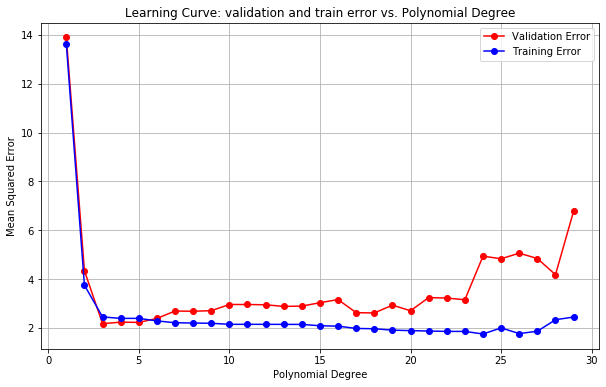

In [64]:
#Calling gridsearch and plotting function
best_model, results = compute_best_fit(X_train, y_train, 29)
plot_learning_curve(X_train, y_train, X_val, y_val, results)

Models with low polynomial degrees (degree 1) typically have high bias because they might underfit the data.
Models with high polynomial degrees (e.g. degree 15 or higher) usually show a high variance because they may have overfit on the training data, capturing noise as well as the signal. This is supported by the graph above, where the MSE is rather high at degree = 1, and the validation error increases as the amount of degrees increases.

## Second experience, using the diabetes dataset

In [74]:
Diabetes = datasets.load_diabetes()

X_db = Diabetes.data
y_db = Diabetes.target

#Splitting dataset into training and validation set
X_train_db, X_val_db, y_train_db, y_val_db = train_test_split(X_db, y_db, test_size=0.2, random_state=0)

#Defining model pipeline
model = Pipeline([
    ('scalar',StandardScaler()),
    ("polynomial", PolynomialFeatures()),
    ("linear", LinearRegression())
])

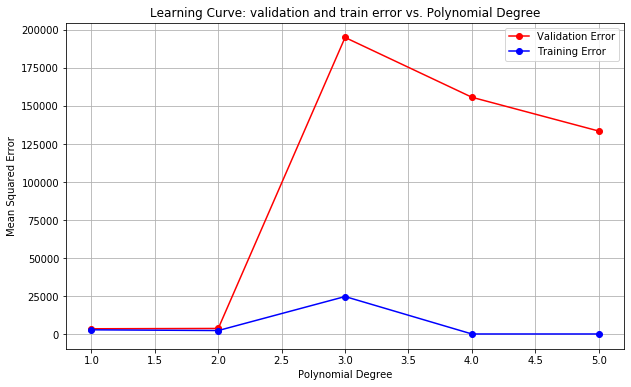

In [73]:
#Calling gridsearch and plotting function
best_model, results = compute_best_fit(X_train_db, y_train_db, 5)
plot_learning_curve(X_train_db, y_train_db, X_val_db, y_val_db, results)

### ROC curve analysis
A common method to evaluate binary classifiers is the receiver operating characteristic (ROC) curve. Similar to the week one practicals, implement a $k$-NN classifier on the breast cancer dataset, however, his time use the $k$-NN pipeline from the preliminary. Train the model for different values of $k$ and evaluate their respective performance with an ROC curve, use the `sklearn.metrics.roc_curve` function.

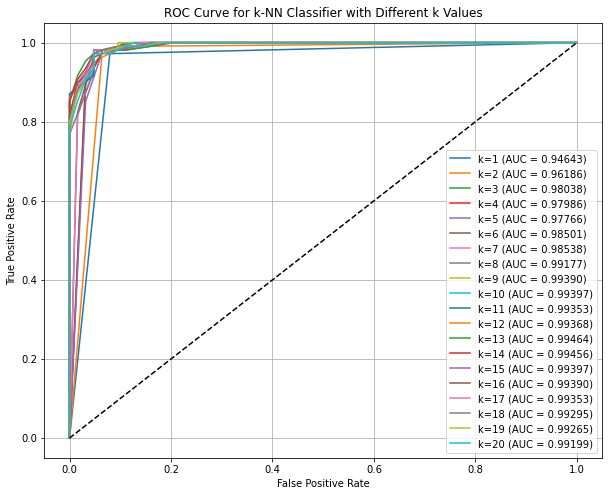

In [23]:
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
from scipy.stats import mode

# Load the breast cancer dataset
data = load_breast_cancer()
X = data.data
y = data.target

def normalize(X):
    mean = np.mean(X, axis=0)
    std = np.std(X, axis=0)
    return (X - mean) / std

X_normalized = normalize(X)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.3, random_state=42)

def euclidean_distance_matrix(X_train, X_test):
    dists = np.sqrt(
        np.sum(X_train**2, axis=1).reshape(-1, 1) + 
        np.sum(X_test**2, axis=1) - 
        2 * np.dot(X_train, X_test.T)
    )
    return dists.T  # transpose

def predict_knn_prob(X_train, y_train, X_test, k):
    # Calculate the distance matrix
    distances = euclidean_distance_matrix(X_train, X_test)
    
    # Get the indices of the k-nearest neighbors
    nearest_neighbor_indices = np.argsort(distances, axis=1)[:, :k]
    
    # Get the labels of the k-nearest neighbors
    nearest_neighbor_labels = y_train[nearest_neighbor_indices]
    
    # Calculate the probability as the fraction of positive labels (class 1)
    probabilities = np.mean(nearest_neighbor_labels, axis=1)
    
    return probabilities

# Evaluate the classifier for different values of k and plot ROC curves
k_values = list(range(1, 21))  # select a few k values to compare
plt.figure(figsize=(10, 8))

for k in k_values:
    # Get predicted probabilities for class 1
    y_prob = predict_knn_prob(X_train, y_train, X_test, k)
    
    # Compute ROC curve and AUC score
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = roc_auc_score(y_test, y_prob)
    
    # Plot ROC curve
    plt.plot(fpr, tpr, label=f'k={k} (AUC = {roc_auc:.5f})')

# Plot the diagonal (random guessing)
plt.plot([0, 1], [0, 1], 'k--')

# Customize the plot
plt.title('ROC Curve for k-NN Classifier with Different k Values')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


### $F_1$ score and Dice similarity coefficient

The Dice similarity coefficient is a very popular evaluation measure for image segmentation applications. Assuming that $A$ is the ground truth segmentation of an object represented as a binary image, and $B$ is the binary output of an image segmentation method, the Dice similarity coefficient is computed as:

$\text{Dice}(A,B) = \frac{2|A\cap B|}{|A| + |B|}$

where $|\cdot|$ represents the cardinality of the objects (e.g. $|A|$ is the number of non-zero pixels in the ground truth segmentation).

For example, the Dice similarity can be computed in the following way:

0.3402777777777778


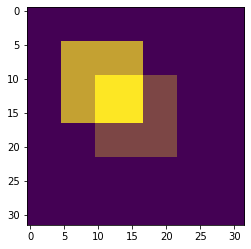

In [14]:
# generate some test objecys
A = np.zeros((32, 32))
A[10:-10, 10:-10] = 1
B = np.zeros((32, 32))
B[5:-15, 5:-15] = 1

dice = 2*np.sum(A*B)/(np.sum(A)+np.sum(B))

# display the results
plt.plot()
plt.imshow(A)
plt.imshow(B, alpha=0.7)

print(dice)

<p><font color='#770a0a'>Show that the $F_1$ score, which is the harmonic mean of precision and recall, is equivalent to the Dice similarity coefficient</font><p>

The $F_{1}$ score is defined as:
$$
F_{1} = \frac{2 \times Precision \times Recall}{Precision + Recall}
$$

With precision being defined as $Precision = \frac{TP}{TP+FP}$ and recall as $Recall = \frac{TP}{TP+FN}$. If we use this in the earlier described equation, we can derive the expression for $F_{1}$ to be equal to:
$$
F_{1} = \frac{2 \times \frac{TP}{TP+FP} \times \frac{TP}{TP+FN}}{\frac{TP}{TP+FP} + \frac{TP}{TP+FN}}
$$
Which we can then further reduce to:
$$
F_{1} = \frac{2 \times \frac{TP^2}{(TP+FP)(TP+FN)}}{\frac{TP}{TP+FP}+\frac{TP}{TP+FN}}
$$
We can now get rid of the fraction in the numerator as follows:
$$
F_{1} = 2 \times\frac{\frac{TP^2}{(TP+FP)(TP+FN)}}{\frac{TP \times (TP+FN)  + TP \times (TP+FP)}{(TP+FP) \times (TP+FN)}}
$$
In this case, the term $(TP+FP)\times(TP+FN)$ cancels out as it is present on both sides of the fraction. This then looks like:
$$
F_{1} = 2 \times \frac{TP^2}{TP \times (TP+FN) + TP \times (TP+FP)}
$$
Which can finally be reduced to:
$$
F_{1} = 2 \times \frac{TP}{2TP+FN+FP}
$$

This is equal to the dice score as |$A\cap B|$ is equal to TP, $|A|$ is equal to $TP + FN$ and $|B|$ is equal to $TP + FP$.